<a href="https://colab.research.google.com/github/GaboLara998/ProyectoIntegrador/blob/main/ProyectoIntregrador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carga de Datos

In [ ]:
# Carga de Datasets
import pandas as pd
import warnings
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize

warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [ ]:
!pip install -U imbalanced-learn

In [ ]:
#Funcion de cargar datasets
def cargar_datos(url):
    datos = pd.read_csv(url, encoding='latin1', skipinitialspace=True)
    return datos

# Función para eliminar columnas no deseadas
def eliminar_columnas(datos, columnas_a_eliminar):
    return datos.drop(columns=columnas_a_eliminar, errors='ignore')


# Función para codificar variables categóricas usando LabelEncoders
def codificar_variables_categoricas(datos, columnas_categoricas):
    encoder = LabelEncoder()
    for columna in columnas_categoricas:
        datos[columna] = encoder.fit_transform(datos[columna])
    return datos

# Función para normalizar todas las características numéricas de un DataFrame
def normalizar_caracteristicas(datos, columnas_categoricas):
    encoder = LabelEncoder()
    scaler = MinMaxScaler()
    for columna in columnas_categoricas:
        datos[columna] = encoder.fit_transform(datos[columna])
    columnas_numericas = datos.select_dtypes(include=['float64', 'int64']).columns
    datos[columnas_numericas] = scaler.fit_transform(datos[columnas_numericas])

    return datos


#Autoencoders

def entrenar_autoencoder(features, dimensiones_intermedias=[32, 16], epochs=50, batch_size=256):
    """
    Entrena un autoencoder y devuelve el modelo junto con el encoder.

    Args:
    - features: Características de entrada para entrenar el autoencoder.
    - dimensiones_intermedias: Lista de enteros que define las dimensiones de las capas intermedias.
    - epochs: Número de épocas para entrenar el autoencoder.
    - batch_size: Tamaño del lote para el entrenamiento.

    Returns:
    - autoencoder: Modelo de autoencoder entrenado.
    - encoder: Parte del encoder del autoencoder para la reducción de la dimensionalidad.
    """
    input_dim = features.shape[1]
    input_layer = Input(shape=(input_dim,))
    encoder_layer = input_layer
    for dim in dimensiones_intermedias:
        encoder_layer = Dense(dim, activation="relu")(encoder_layer)
    decoder_layer = Dense(dimensiones_intermedias[-2], activation="relu")(encoder_layer)
    for dim in reversed(dimensiones_intermedias[:-1]):
        decoder_layer = Dense(dim, activation="relu")(decoder_layer)
    decoder_layer = Dense(input_dim, activation="sigmoid")(decoder_layer)

    autoencoder = Model(input_layer, decoder_layer)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(features, features, epochs=epochs, batch_size=batch_size, shuffle=True, validation_split=0.2)

    encoder = Model(input_layer, encoder_layer)
    return autoencoder, encoder

def transformar_con_autoencoder(encoder, features):
    """
    Transforma las características utilizando el encoder de un autoencoder entrenado.

    Args:
    - encoder: El encoder de un autoencoder.
    - features: Características a transformar.

    Returns:
    - Características transformadas.
    """
    return encoder.predict(features)

# Pruebas

In [ ]:
# URLs de los conjuntos de datos
url_training = "https://raw.githubusercontent.com/GaboLara998/ProyectoIntegrador/main/DataSet_UNSW_NB15/UNSW_NB15_training-set.csv?token=GHSAT0AAAAAACMBWAOFBU5CFZ67HIDC2XLOZO7JZMA"
url_testing = "https://raw.githubusercontent.com/GaboLara998/ProyectoIntegrador/main/DataSet_UNSW_NB15/UNSW_NB15_testing-set.csv?token=GHSAT0AAAAAACMBWAOFEFKXDJN42NYN2ZDAZO7JXNA"




# Cargar los datos
datos_training = cargar_datos(url_training)
datos_testing = cargar_datos(url_testing)

# Columnas sin considerar
columnas_a_eliminar = ['id']
# Columnas categóricas
columnas_categoricas = ['proto', 'service', 'state', 'attack_cat']

# Eliminar columnas no deseadas
datos_training = eliminar_columnas(datos_training, columnas_a_eliminar)
datos_testing = eliminar_columnas(datos_testing, columnas_a_eliminar)

# Manejar valores faltantes
#datos_training = manejar_valores_faltantes(datos_training)
#datos_testing = manejar_valores_faltantes(datos_testing)

# Preprocesar datos
datos_training = normalizar_caracteristicas(datos_training, columnas_categoricas)
datos_testing = normalizar_caracteristicas(datos_testing, columnas_categoricas)



# Separa las características y las etiquetas en el conjunto de entrenamiento
X = datos_training.drop('label', axis=1)
y = datos_training['label']

# Aplicar SMOTE para tratar el desequilibrio de clases en el conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X, y)

# Ahora proceder a entrenar tu autoencoder y otros modelos con X_sm y y_sm
# Entrenamiento y transformación con Autoencoder
autoencoder, encoder = entrenar_autoencoder(X_sm.to_numpy())
features_training_reduced = transformar_con_autoencoder(encoder, X_sm.to_numpy())





KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV
# Definir los parámetros a optimizar
param_grid = {'n_estimators': [50, 100, 200], 'contamination': ['auto', 0.1, 0.2, 0.3]}
# Definir la métrica de puntuación personalizada
scorer = make_scorer(mean_squared_error)

# Crear el objeto GridSearchCV con la métrica de puntuación personalizada
grid_search = GridSearchCV(IsolationForest(random_state=42), param_grid, cv=5, scoring=scorer)

# Ajustar el modelo a los datos
grid_search.fit(features_training_reduced)

# Imprimir los mejores parámetros
print(grid_search.best_params_)
#{'contamination': 'auto', 'n_estimators': 50}


In [ ]:
print(datos_testing.describe())
print(datos_testing.info())

In [ ]:
print(datos_training.describe())
print(datos_training.info())

# Implementación de Algoritmos

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 4.6 MB/s eta 0:00:00


In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import shap

# No considerarar la columna de etiquetas antes de entrenar el autoencoder
features_training = datos_training.drop(columns=['label'], errors='ignore')
features_testing = datos_testing.drop(columns=['label'], errors='ignore')

# Entrenamiento y transformación con Autoencoder
autoencoder, encoder = entrenar_autoencoder(features_training.to_numpy())
features_training_reduced = transformar_con_autoencoder(encoder, features_training.to_numpy())
features_testing_reduced = transformar_con_autoencoder(encoder, features_testing.to_numpy())

# Entrenamiento de Isolation Forest y One-Class SVM con características reducidas
isolation_forest = IsolationForest(n_estimators=50, contamination='auto', random_state=42)
isolation_forest.fit(features_training_reduced)

one_class_svm = OneClassSVM(kernel='rbf', gamma='auto')
one_class_svm.fit(features_training_reduced)

# Preprocesamiento de Datos

In [ ]:

# Crear un objeto explainer para cada modelo
explainer_if = shap.TreeExplainer(isolation_forest)
explainer_svm = shap.KernelExplainer(one_class_svm.predict, features_training_reduced)

# Calcular los valores SHAP para cada modelo
shap_values_if = explainer_if.shap_values(features_training_reduced)
shap_values_svm = explainer_svm.shap_values(features_training_reduced)

# Visualizar los valores SHAP para la primera predicción de cada modelo
shap.force_plot(explainer_if.expected_value, shap_values_if[0,:], features_training_reduced.iloc[0,:])
shap.force_plot(explainer_svm.expected_value, shap_values_svm[0,:], features_training_reduced.iloc[0,:])

# Transformación de los datos de prueba
features_testing_reduced = transformar_con_autoencoder(encoder, datos_testing.drop('label', axis=1).to_numpy())

# Predicciones para los modelos
predictions_isolation_forest = isolation_forest.predict(features_testing_reduced)
predictions_one_class_svm = one_class_svm.predict(features_testing_reduced)

# Convertir las predicciones de -1, 1 a 0, 1
predictions_isolation_forest_binarized = (predictions_isolation_forest < 0).astype(int)
predictions_one_class_svm_binarized = (predictions_one_class_svm < 0).astype(int)

# Etiquetas de prueba reales
labels_testing_binarized = label_binarize(datos_testing['label'], classes=[0, 1]).ravel()

# Cálculo de métricas
precision_if = precision_score(labels_testing_binarized, predictions_isolation_forest_binarized)
recall_if = recall_score(labels_testing_binarized, predictions_isolation_forest_binarized)
f1_score_if = f1_score(labels_testing_binarized, predictions_isolation_forest_binarized)

precision_svm = precision_score(labels_testing_binarized, predictions_one_class_svm_binarized)
recall_svm = recall_score(labels_testing_binarized, predictions_one_class_svm_binarized)
f1_score_svm = f1_score(labels_testing_binarized, predictions_one_class_svm_binarized)

print(f"Isolation Forest - Precisión: {precision_if}, Recall: {recall_if}, F1-Score: {f1_score_if}")
print(f"One-Class SVM - Precisión: {precision_svm}, Recall: {recall_svm}, F1-Score: {f1_score_svm}")

In [ ]:
# Revisar balanceo de datos
# Random Forest y normalizacion de datos
# seleccion de mejores caracteristicas
# extraer las caracteristicas



# Comparar efectividad


#Mejorar resultados usar busqeuda de cuadricula o busqueda aleatorioa.
# seleccionar caracteristicas como el PCA

#Probar red reuronal,

# usar weka para ver mejores caracteristicas
# boxplot de cada set, para cada variable y vemos como se mueven las mdeidas de cada atributo para analizar la dispersion o incluso outliders

#Balanceo de Clases


In [ ]:
#Isolation Forest
#from sklearn.ensemble import IsolationForest

# Instancia del modelo Isolation Forest
#isolation_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

# Entrenamiento del modelo con los datos de entrenamiento (sin incluir la etiqueta)
# Asumiendo que 'label' es la columna de etiquetas y ha sido removida de features_training_normalized
#isolation_forest.fit(datos_training)


#OneClassSVM
#from sklearn.svm import OneClassSVM

# Instancia del modelo One-Class SVM
#one_class_svm = OneClassSVM(kernel='rbf', gamma='auto')

# Entrenamiento del modelo con los datos de entrenamiento
#one_class_svm.fit(datos_training)

# Segundo enfoque

In [1]:
#Segundo intento
import pandas as pd
import warnings
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

#Funcion de cargar datasets
def cargar_datos(link):
    datos = pd.read_csv(link, encoding='latin1', skipinitialspace=True)
    return datos


def aplicarLabelEncoder(dataset):
    encoder = LabelEncoder()
    for columna in dataset.columns:
        dataset[columna] = encoder.fit_transform(dataset[columna])
    return dataset

#Links datasets
link_training = "https://raw.githubusercontent.com/GaboLara998/ProyectoIntegrador/main/DataSet_UNSW_NB15/UNSW_NB15_training-set.csv?token=GHSAT0AAAAAACMBWAOFBU5CFZ67HIDC2XLOZO7JZMA"
link_testing = "https://raw.githubusercontent.com/GaboLara998/ProyectoIntegrador/main/DataSet_UNSW_NB15/UNSW_NB15_testing-set.csv?token=GHSAT0AAAAAACMBWAOFEFKXDJN42NYN2ZDAZO7JXNA"


# Cargar los datos
datos_training = cargar_datos(link_training)
datos_testing = cargar_datos(link_testing)

UnificacionDatos=[datos_testing,datos_training]
datasetFinal=pd.concat(UnificacionDatos)


datasetFinal=aplicarLabelEncoder(datasetFinal)


#Seleccion de caracteristicas y clase de salida
X_features=datasetFinal.iloc[:,1:45]
y_label=datasetFinal.iloc[:,0]


In [2]:
# Crear el objeto MinMaxScaler
scaler = MinMaxScaler()

# Ajustar y transformar las características
X_scaled = scaler.fit_transform(X_features)

# Convertir X_scaled a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X_features.columns)

# Imprimir el DataFrame escalado
print(X_scaled_df)

             dur     proto   service  state     spkts    dpkts    sbytes  \
0       0.000100  0.901515  0.000000    0.5  0.001550  0.00000  0.024091   
1       0.000073  0.901515  0.000000    0.5  0.001550  0.00000  0.095086   
2       0.000045  0.901515  0.000000    0.5  0.001550  0.00000  0.056497   
3       0.000055  0.901515  0.000000    0.5  0.001550  0.00000  0.047436   
4       0.000091  0.901515  0.000000    0.5  0.001550  0.00000  0.115020   
...          ...       ...       ...    ...       ...      ...       ...   
257668  0.000082  0.901515  0.166667    0.5  0.001550  0.00000  0.003198   
257669  0.389808  0.856061  0.000000    0.4  0.013953  0.01278  0.031233   
257670  0.000082  0.901515  0.166667    0.5  0.001550  0.00000  0.003198   
257671  0.000082  0.901515  0.166667    0.5  0.001550  0.00000  0.003198   
257672  0.000082  0.901515  0.166667    0.5  0.001550  0.00000  0.003198   

          dbytes      rate      sttl  ...  ct_dst_sport_ltm  ct_dst_src_ltm  \
0       

             dur     proto   service  state      sttl     smean  trans_depth  \
0       0.000100  0.901515  0.000000    0.5  0.916667  0.153343          0.0   
1       0.000073  0.901515  0.000000    0.5  0.916667  0.613372          0.0   
2       0.000045  0.901515  0.000000    0.5  0.916667  0.361192          0.0   
3       0.000055  0.901515  0.000000    0.5  0.916667  0.300145          0.0   
4       0.000091  0.901515  0.000000    0.5  0.916667  0.745640          0.0   
...          ...       ...       ...    ...       ...       ...          ...   
257668  0.000082  0.901515  0.166667    0.5  0.916667  0.014535          0.0   
257669  0.389808  0.856061  0.000000    0.4  0.916667  0.018169          0.0   
257670  0.000082  0.901515  0.166667    0.5  0.916667  0.014535          0.0   
257671  0.000082  0.901515  0.166667    0.5  0.916667  0.014535          0.0   
257672  0.000082  0.901515  0.166667    0.5  0.916667  0.014535          0.0   

        ct_srv_src  ct_dst_ltm  ct_src_

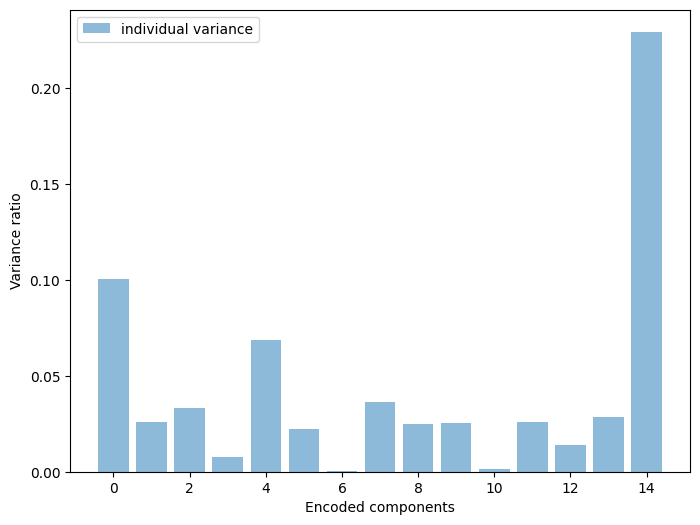

In [3]:
#Principle Component Analysis
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model


# Seleccionar características basadas en la correlación de Spearman
corr_spearman = X_scaled_df.corr(method='spearman')
highly_correlated_features = set()

for i in range(len(corr_spearman.columns)):
    for j in range(i):
        if abs(corr_spearman.iloc[i, j]) > 0.8:  # Puedes ajustar este umbral según tus necesidades
            colname = corr_spearman.columns[i]
            highly_correlated_features.add(colname)

selected_features = [col for col in X_scaled_df.columns if col not in highly_correlated_features]

# Crear un nuevo DataFrame con las características seleccionadas
X_selected_features = X_scaled_df[selected_features]

# Imprimir las características seleccionadas
print(X_selected_features)

# Definir la arquitectura del autoencoder
input_dim = X_selected_features.shape[1]
encoding_dim = 10  # ajusta esta dimensión según tus necesidades

input_data = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_data)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_data, decoded)

# Compilar y entrenar el autoencoder
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(X_selected_features, X_selected_features, epochs=10, batch_size=32)

# Obtener las representaciones codificadas de los datos
encoded_data = autoencoder.predict(X_selected_features)

# Calcular la varianza de las representaciones codificadas
encoded_variance = encoded_data.var(axis=0)

# Imprimir la varianza de las representaciones codificadas
plt.figure(figsize=(8, 6))
plt.bar(range(len(encoded_variance)), encoded_variance, alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Encoded components')
plt.show()

In [7]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.ensemble import IsolationForest

# Crear el clasificador Isolation Forest
iforest = IsolationForest(contamination=0.1, random_state=42)  # Puedes ajustar el valor de "contamination"

# Entrenar el modelo Isolation Forest
iforest.fit(X_selected_features)

# Predecir las etiquetas de anomalía (-1 para anomalía, 1 para no anomalía)
anomaly_labels = iforest.predict(X_selected_features)

# Contar el número de anomalías y no anomalías
n_anomalies = (anomaly_labels == -1).sum()
n_normals = (anomaly_labels == 1).sum()

# Imprimir el número de anomalías y no anomalías
print("Número de anomalías:", n_anomalies)
print("Número de instancias normales:", n_normals)

Número de anomalías: 25767
Número de instancias normales: 231906


In [8]:
from sklearn.svm import OneClassSVM

# Crear el clasificador One-Class SVM
ocsvm = OneClassSVM(nu=0.1)  # Puedes ajustar el valor de "nu"

# Entrenar el modelo One-Class SVM
ocsvm.fit(X_selected_features)

# Predecir las etiquetas de anomalía (-1 para anomalía, 1 para no anomalía)
anomaly_labels_ocsvm = ocsvm.predict(X_selected_features)

# Contar el número de anomalías y no anomalías
n_anomalies_ocsvm = (anomaly_labels_ocsvm == -1).sum()
n_normals_ocsvm = (anomaly_labels_ocsvm == 1).sum()

# Imprimir el número de anomalías y no anomalías
print("Número de anomalías (One-Class SVM):", n_anomalies_ocsvm)
print("Número de instancias normales (One-Class SVM):", n_normals_ocsvm)


Número de anomalías (One-Class SVM): 25630
Número de instancias normales (One-Class SVM): 232043


In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Calcular las métricas para Isolation Forest
iforest_scores = iforest.decision_function(X_selected_features)
iforest_labels = iforest.predict(X_selected_features)

# Calcular las métricas para One-Class SVM
ocsvm_scores = ocsvm.decision_function(X_selected_features)
ocsvm_labels = ocsvm.predict(X_selected_features)

# Definir las etiquetas verdaderas (1 para instancias normales, -1 para anomalías)
true_labels = y_label  # Suponiendo que 'y_label' contiene las etiquetas verdaderas

# Convertir las etiquetas de anomalía de los modelos en 1 para instancias normales y -1 para anomalías
iforest_labels = (iforest_labels == 1).astype(int)
ocsvm_labels = (ocsvm_labels == 1).astype(int)


In [19]:
# Convertir las etiquetas de anomalía en binarias (1 para instancias normales, -1 para anomalías)
binary_true_labels = (true_labels == 1).astype(int)

# Calcular las métricas para Isolation Forest
precision_iforest = precision_score(true_labels, iforest_labels, average='macro')
recall_iforest = recall_score(true_labels, iforest_labels, average='macro')
f1_score_iforest = f1_score(true_labels, iforest_labels, average='macro')
auc_iforest = roc_auc_score(binary_true_labels, -iforest_scores)
print("Métricas de Isolation Forest:")
print("Precisión:", precision_iforest)
print("Recall:", recall_iforest)
print("F1-score:", f1_score_iforest)
print("AUC:", auc_iforest)
print()

# Calcular las métricas para One-Class SVM
precision_ocsvm = precision_score(true_labels, ocsvm_labels, average='macro')
recall_ocsvm = recall_score(true_labels, ocsvm_labels, average='macro')
f1_score_ocsvm = f1_score(true_labels, ocsvm_labels, average='macro')
auc_ocsvm = roc_auc_score(binary_true_labels, -ocsvm_scores)  # Usar los scores negativos para AUC
print("Métricas de One-Class SVM:")
print("Precisión:", precision_ocsvm)
print("Recall:", recall_ocsvm)
print("F1-score:", f1_score_ocsvm)
print("AUC:", auc_ocsvm)


Métricas de Isolation Forest:
Precisión: 4.9185210171009634e-11
Recall: 5.70317267495908e-06
F1-score: 9.836957198473671e-11
AUC: 0.7949099821089685

Métricas de One-Class SVM:
Precisión: 0.0
Recall: 0.0
F1-score: 0.0
AUC: 0.937233914565473


In [21]:
# Convertir las etiquetas de anomalía en binarias (1 para instancias normales, -1 para anomalías)
binary_true_labels = (true_labels == 1).astype(int)

# Calcular las métricas para Isolation Forest
precision_iforest = precision_score(binary_true_labels, iforest_labels, average='macro')
recall_iforest = recall_score(binary_true_labels, iforest_labels, average='macro')
f1_score_iforest = f1_score(binary_true_labels, iforest_labels, average='macro')
auc_iforest = roc_auc_score(binary_true_labels, -iforest_scores)
print("Métricas de Isolation Forest:")
print("Precisión:", precision_iforest)
print("Recall:", recall_iforest)
print("F1-score:", f1_score_iforest)
print("AUC:", auc_iforest)
print()

# Calcular las métricas para One-Class SVM
precision_ocsvm = precision_score(binary_true_labels, ocsvm_labels, average='macro')
recall_ocsvm = recall_score(binary_true_labels, ocsvm_labels, average='macro')
f1_score_ocsvm = f1_score(binary_true_labels, ocsvm_labels, average='macro')
auc_ocsvm = roc_auc_score(binary_true_labels, -ocsvm_scores)  # Usar los scores negativos para AUC
print("Métricas de One-Class SVM:")
print("Precisión:", precision_ocsvm)
print("Recall:", recall_ocsvm)
print("F1-score:", f1_score_ocsvm)
print("AUC:", auc_ocsvm)


Métricas de Isolation Forest:
Precisión: 0.5000043120919683
Recall: 0.5499998059541042
F1-score: 0.0909173942815207
AUC: 0.7949099821089685

Métricas de One-Class SVM:
Precisión: 0.4999609832227858
Recall: 0.049730082159032254
F1-score: 0.09046208802651595
AUC: 0.937233914565473


#Comparacion de algoritmos

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Crear un clasificador de Random Forest
rf_classifier = RandomForestClassifier()

# Entrenar el clasificador de Random Forest
rf_classifier.fit(X_scaled, y_label)

# Obtener la importancia de las características
feature_importances = rf_classifier.feature_importances_

# Crear un DataFrame para visualizar la importancia de las características
feature_importance_df = pd.DataFrame({'Feature': X_features.columns, 'Importance': feature_importances})

# Ordenar las características por importancia en orden descendente
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Imprimir las características ordenadas por importancia
print(feature_importance_df)